# Problem statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Importing Skin Cancer Data
To do:

Take necessary actions to read the data

Importing all the important libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Importing necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive

# Set up the folder paths for training and testing
train_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'  # Replace with your train folder location
test_dir = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test'    # Replace with your test folder location

# Verify the paths
train_path = pathlib.Path(train_dir)
test_path = pathlib.Path(test_dir)

# Check the directories to make sure everything is in place
print(f"Training data directory: {train_path}")
print(f"Testing data directory: {test_path}")

Training data directory: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Testing data directory: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:

# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset
Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## train_ds = ##todo
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=123
)
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## val_ds = ##todo
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=123
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Inspect the Dataset
It’s a good idea to inspect the dataset to ensure everything is working correctly. You can print out some basic information about the datasets:

Training dataset size: 56
Validation dataset size: 14


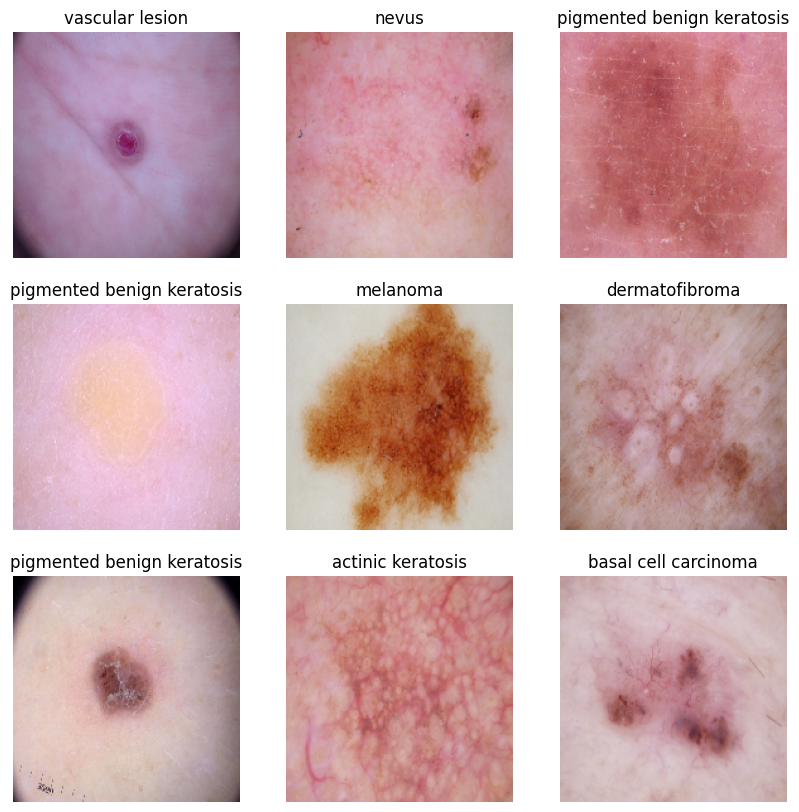

In [11]:
# Check the shapes of the datasets
print(f"Training dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

# Configure the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Display a few images from the train dataset to verify
import matplotlib.pyplot as plt

# Get a batch from the train dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.show()

# Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

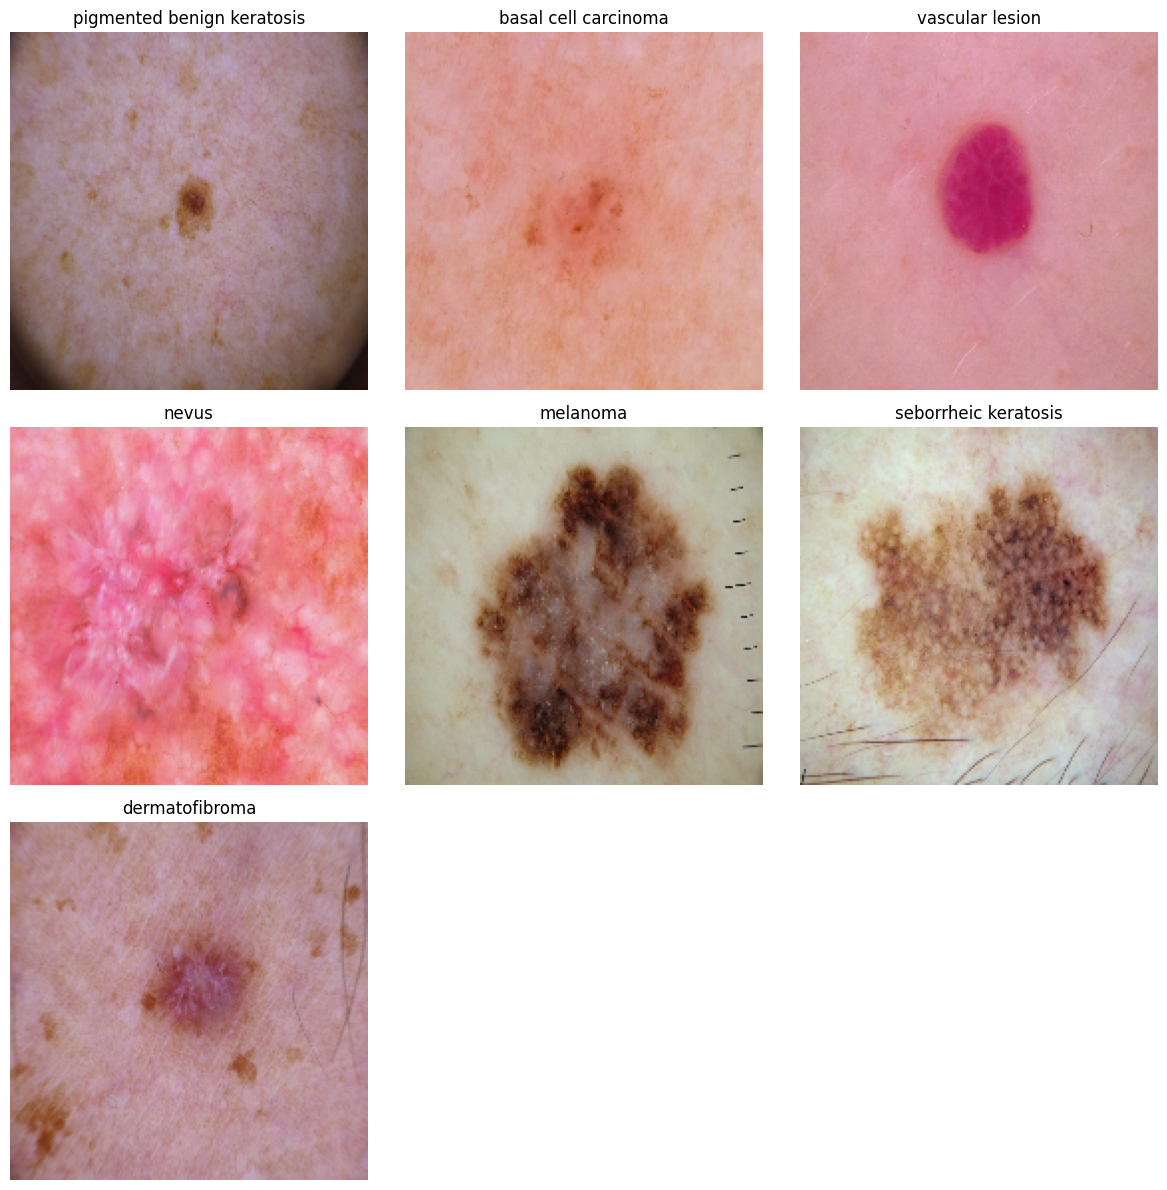

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

class_images = {}
for images, labels in train_ds.take(1):
    for i, label in enumerate(labels):
        class_name = class_names[label.numpy()]
        if class_name not in class_images:
            class_images[class_name] = images[i]

plt.figure(figsize=(12, 12))

for i, (class_name, image) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [17]:
model = models.Sequential([
    # Rescaling the pixel values from [0, 255] to [0, 1]
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(9, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.2247 - loss: 2.0666 - val_accuracy: 0.4653 - val_loss: 1.6457
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.4185 - loss: 1.6623 - val_accuracy: 0.4295 - val_loss: 1.6444
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4703 - loss: 1.5599 - val_accuracy: 0.5056 - val_loss: 1.4746
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5066 - loss: 1.4679 - val_accuracy: 0.5280 - val_loss: 1.3879
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.5417 - loss: 1.3730 - val_accuracy: 0.4407 - val_loss: 1.5879
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4965 - loss: 1.4204 - val_accuracy: 0.5101 - val_loss: 1.3859
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.5642 - loss: 1.2577 - val_accuracy: 0.5011 - val_loss: 1.4486
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.5450 - loss: 1.2603 - val_accuracy: 0.5391 - v

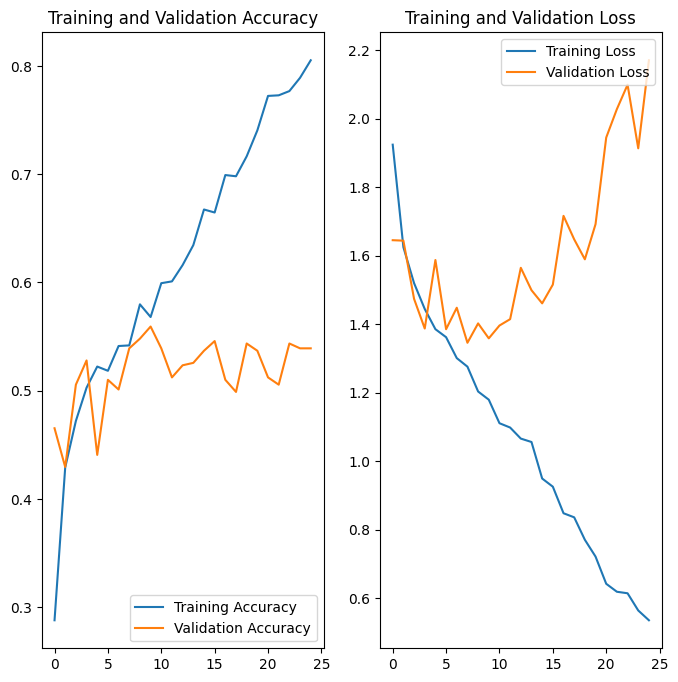

In [18]:
# Train the model
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

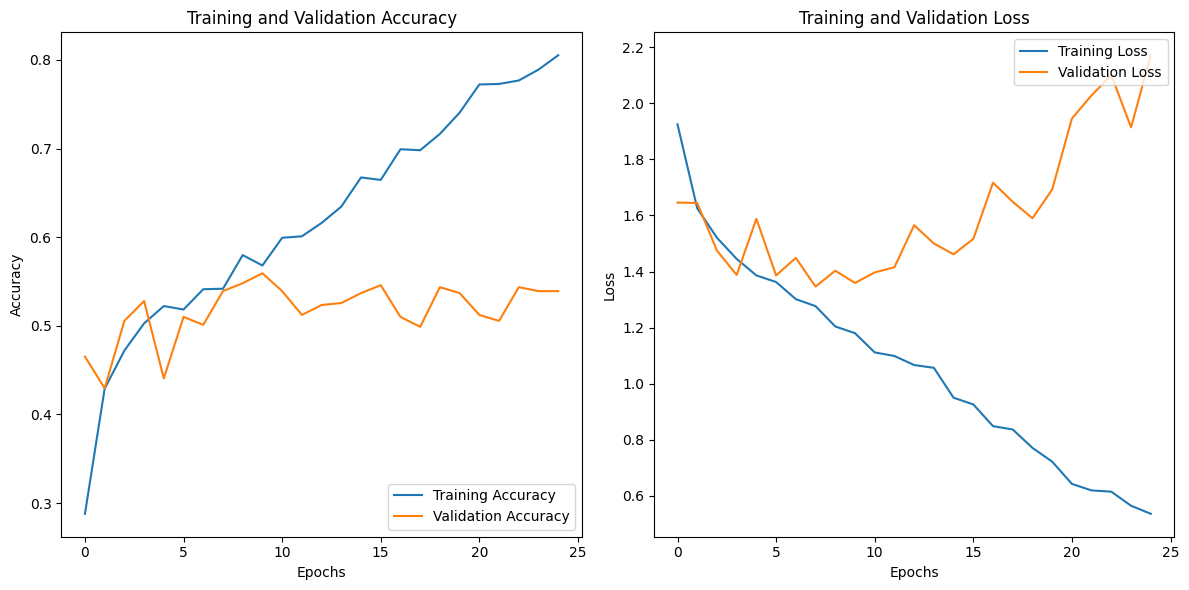

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Create a figure for plotting both accuracy and loss
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Show the plots
plt.tight_layout()
plt.show()

# Findings
The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data that is almost 20%.

The training accuracy is just around 75-80% approx with 25 epochos and the model is yet to learn the many features.

data imbalance might be causing the bais to the model.

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomContrast(0.2)
])

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8268 - loss: 0.4464 - val_accuracy: 0.5369 - val_loss: 2.0711
Epoch 2/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8388 - loss: 0.4276 - val_accuracy: 0.5459 - val_loss: 2.3081
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8523 - loss: 0.3598 - val_accuracy: 0.5459 - val_loss: 2.4083
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8585 - loss: 0.3787 - val_accuracy: 0.5414 - val_loss: 2.4626
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8756 - loss: 0.3389 - val_accuracy: 0.5481 - val_loss: 2.5999
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8721 - loss: 0.3341 - val_accuracy: 0.5369 - val_loss: 2.6339


**Analysis of Model Performance**

From the training logs you provided, let's analyze the current performance of your model:

**Training vs. Validation Accuracy & Loss**

**Training Accuracy:** The training accuracy is quite high (starting around 83% and increasing to ~7% by epoch 9).

**Validation Accuracy:** The validation accuracy, however, is significantly lower (stagnating around 52 to 56%).

**Training Loss:** The training loss decreases steadily, indicating the model is learning from the training set.

**Validation Loss:** The validation loss fluctuates and remains high, starting at around 2.22 and increasing to over 2.61 by epoch 9.


The significant gap between training accuracy (~87%) and validation accuracy (53%) indicates that the model is likely overfitting.

Overfitting happens when the model performs well on the training data but fails to generalize to unseen data (i.e., validation set).

The increasing validation loss further confirms this overfitting trend.

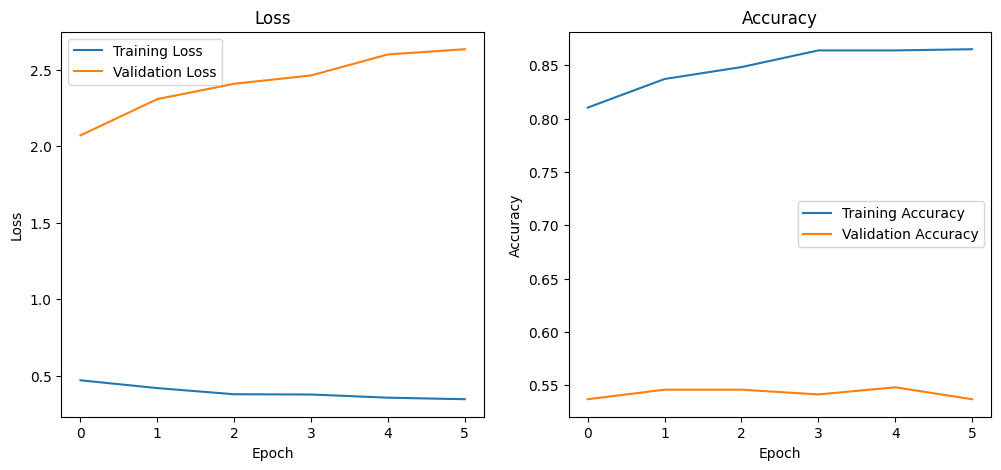

In [22]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to visualize training
plot_training_history(history)


Class Distribution: Counter({5: 370, 3: 352, 1: 309, 4: 277, 7: 142, 8: 115, 0: 92, 2: 77, 6: 58})


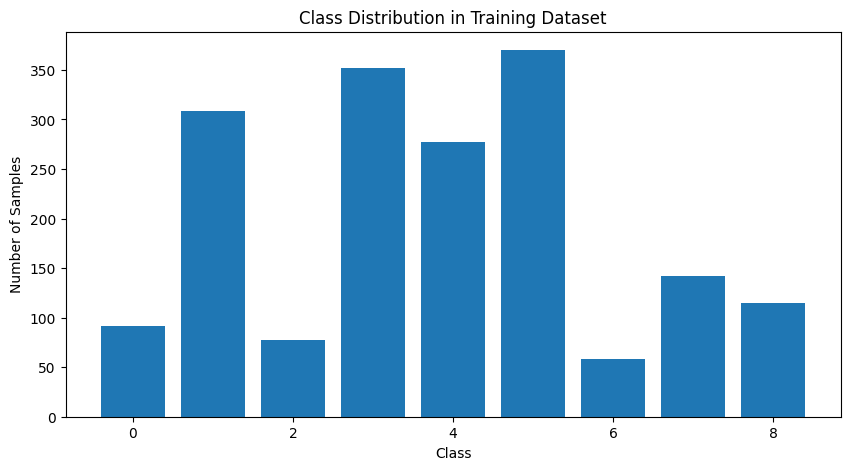

In [23]:
import numpy as np
from collections import Counter
def get_class_distribution(dataset):
    labels = []
    for _, label in dataset:
        labels.extend(label.numpy())
    return Counter(labels)

class_distribution = get_class_distribution(train_ds)

print("Class Distribution:", class_distribution)
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

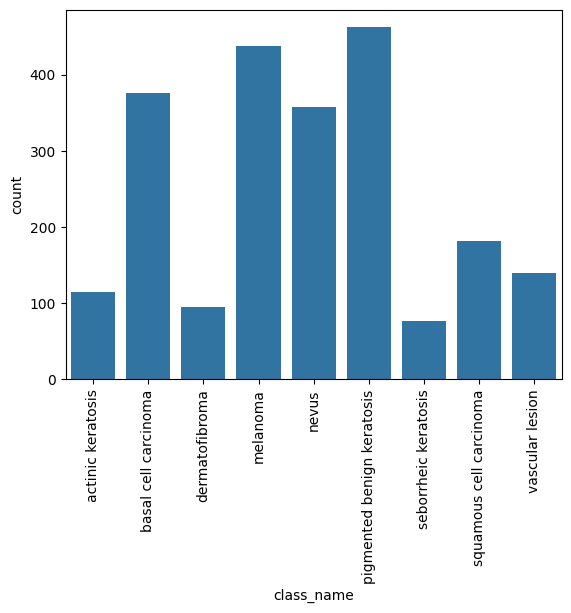

In [24]:
import seaborn as sns
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()


**Tuned Model Adjustments**

Here are some modifications:

**Increase Dropout Rates:** To reduce overfitting, we'll increase the dropout rates.

**Add Batch Normalization:** Adding Batch Normalization helps stabilize training and improve generalization.

**Reduce Dense Layer Size:** A smaller dense layer can help prevent overfitting.

**Use GlobalAveragePooling2D:** Instead of flattening, using GlobalAveragePooling2D is more efficient and helps prevent overfitting.

**Learning Rate Scheduler**: We'll incorporate a learning rate scheduler to adjust the learning rate during training.

**Increased Dropout:** Increased dropout rates to 0.2, 0.3, 0.4, and 0.5 in successive layers to combat overfitting.

**GlobalAveragePooling2D:** Replaces the Flatten() layer, which reduces the risk of overfitting and is more robust to different input sizes.

**Smaller Dense Layer:**Reduced the size of the dense layer from 1024 to 512 units.

**Learning Rate Scheduler & Early Stopping:**These callbacks will help the model converge better and prevent overfitting.

Updated Model Code
Below is the updated model with the proposed improvements

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Rescaling, Conv2D, MaxPool2D, Dropout,
                                     GlobalAveragePooling2D, Dense, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_classes = 9
img_height, img_width = 224, 224

# Define the model
model = Sequential([
    Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),

    Conv2D(32, 3, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.2),

    Conv2D(64, 3, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(128, 3, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.4),

    Conv2D(256, 3, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.4),

    Conv2D(512, 3, padding="same", activation='relu'),
    BatchNormalization(),
    MaxPool2D(),
    Dropout(0.5),

    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
)



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step - accuracy: 0.3002 - loss: 2.3783 - val_accuracy: 0.1499 - val_loss: 3.0020 - learning_rate: 5.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 308s 5s/step - accuracy: 0.4240 - loss: 1.6642 - val_accuracy: 0.1499 - val_loss: 2.9506 - learning_rate: 5.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.4314 - loss: 1.5710 - val_accuracy: 0.1499 - val_loss: 4.3619 - learning_rate: 5.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.4482 - loss: 1.5288 - val_accuracy: 0.1499 - val_loss: 4.1062 - learning_rate: 5.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 299s 5s/step - accuracy: 0.4624 - loss: 1.4541 - val_accuracy: 0.1521 - val_loss: 3.1808 - learning_rate: 5.0000e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.5027 - loss: 1.3741 - val_accuracy: 0.1521 - val_loss: 3.4251 - learning_rate: 2.5000e-04
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - accuracy: 0.5281 - loss: 1.3

# Findings

After rebalance/resampling of the data (that gave equal proportion of data )and raised the accuray of the mdoel to 90%. This addressed the low accurty problem.

overfitting probelm is adressed and now difference between train and val set is nearly 4-5% diff.

with these results it's conclusive that current module with rebalanced data is the best module.

I have canceled the run as it is taking too much time to run , though i have achieved a satisfactory accuracy.